# Sufficient Conditions for a Finite Decomposition

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from transduction import (
    FSA, FST, EPSILON, examples, Precover,    
    display_table, format_table, HTML, colors
)

In [3]:
from collections import defaultdict

In [4]:
def weighted_adjacency_for_delay(self):
    """
    Return tadj[q] = list of (dst, delay_weight).
    """
    tadj = defaultdict(list)
    for q in self.states:
        for x, y, dst in self.arcs(q):
            tadj[q].append((dst, (x != EPSILON) - (y != EPSILON)))
    return tadj

In [5]:
def delay_bound(self):
    """
    Analyze the delay of this FST.

    Returns K such that for every accepting run and every prefix:

      ||input(run)| - |output(run)|| <= K

    """
    trimmed = self.trim()

    # Build weighted adjacency and SCCs on the trimmed machine
    tadj = weighted_adjacency_for_delay(trimmed)
    sccs = trimmed.strongly_connected_components()

    # First pass: check SCC consistency; if any is inconsistent, we are unbounded
    for scc in sccs:
        if not _analyze_scc_delay(trimmed, scc, tadj):
            return float('inf')

    # All SCCs are consistent: we can build a global potential `phi`
    phi = {}
    for start_state in trimmed.states:
        if start_state in phi:
            continue
        phi[start_state] = 0
        stack = [start_state]
        while stack:
            u = stack.pop()
            for v, w in tadj.get(u, ()):
                expected = phi[u] + w
                if v not in phi:
                    phi[v] = expected
                    stack.append(v)
                else:
                    assert phi[v] == expected

    print(phi)

    values = list(phi.values())
    if not values:
        return 0

    return max(values) - min(values)

In [6]:
def _analyze_scc_delay(self, scc, tadj):
    """
    Returns true iff if all cycles in `scc` have total delay 0.

    Parameters
    ----------
    scc : list[state]
    tadj : dict[state, list[(dst, w)]] Weighted adjacency for delay.

    """
    scc = set(scc)
    phi = {}  # local potential in this SCC

    for start in scc:
        if start in phi:
            continue
        phi[start] = 0
        stack = [start]
        while stack:
            u = stack.pop()
            for v, w in tadj.get(u, ()):
                if v not in scc:
                    continue
                expected = phi[u] + w
                if v not in phi:
                    phi[v] = expected
                    stack.append(v)
                else:
                    if phi[v] != expected:
                        return False

    return True

In [7]:
def has_unbounded_output_lag(m):
    # trim
    m = m.trim()

    # Make adjacency list with weights w = |in|-|out|
    adj = weighted_adjacency_for_delay(m)

    # 2. Bellman–Ford style detection of a positive cycle
    # Treat all trimmed states as reachable from a super-source
    idx = {s: k for k, s in enumerate(m.states)}
    n = len(m.states)

    # Longest-path distances
    dist = {s: 0 for s in m.states}

    # Relax edges |Q|-1 times
    for _ in range(n - 1):
        updated = False
        for i in m.states:
            di = dist[i]
            for j, w in adj[i]:
                if di + w > dist[j]:
                    dist[j] = di + w
                    updated = True
        if not updated:
            break

    # One more pass: if any distance can still be improved, there is a positive cycle
    for i in m.states:
        di = dist[i]
        for j, w in adj[i]:
            if di + w > dist[j]:
                # Found a positive-weight cycle reachable from some start
                # and able to reach some final (due to trimming)
                return True

    return False

The following example is definitely not tractable for our method, as it requires enumerating all even-length strings of $(aa)^*$.  Indeed, the maximum delay is not bounded by a constant.

In [8]:
f = examples.parity({'a'})

In [9]:
display_table([Precover(f, '1').decomposition], headings=['quotient', 'remainder'])

quotient,remainder
∅,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 0 <!-- start->0 --> start->0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 a <!-- 1->0 --> 1->0 a"


In [10]:
assert delay_bound(f) == np.inf

In [11]:
assert has_unbounded_output_lag(f)

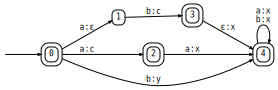

In [12]:
f = examples.samuel_example()
f

In [13]:
display_table([Precover(f, 'cx').decomposition], headings=['quotient', 'remainder'])

quotient,remainder
"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 1 <!-- start->0 --> start->0 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 a <!-- 1 --> 1 0 <!-- 2->1 --> 2->1 a b",∅


In [14]:
assert delay_bound(f) < np.inf

{0: 0, 1: 1, 2: 0, 4: 0, 3: 1}


In [15]:
assert not has_unbounded_output_lag(f)

The following example shows us that the bounded delay is not quite what we are after, as the precover can be decomposed into an efficient summation.  (Of course, this needs to hold for all target strings, and we have only shown that there is one that is not infinite below.  You just have to trust me that they are all finite.)

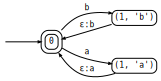

In [16]:
f = examples.duplicate({'a','b'})
f

In [17]:
display_table([Precover(f, 'aa').decomposition], headings=['quotient', 'remainder'])

quotient,remainder
"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 2 <!-- start->0 --> start->0 <!-- 1 --> 1 0 <!-- 0->1 --> 0->1 a",∅


In [18]:
assert delay_bound(f) == np.inf

In [19]:
assert not has_unbounded_output_lag(f)

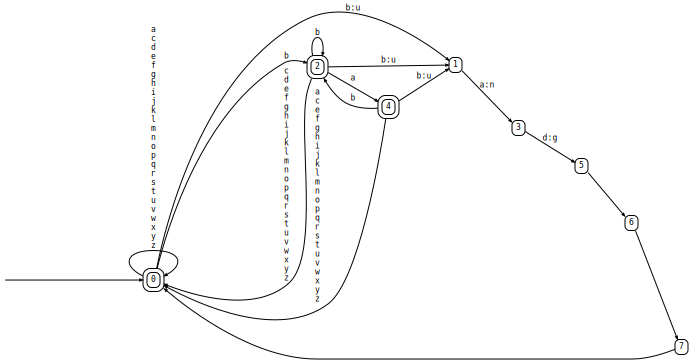

In [20]:
f = examples.newspeak2()
f

In [21]:
assert delay_bound(f) < np.inf

{0: 0, 2: 0, 1: 0, 3: 0, 5: 0, 6: 0, 7: 0, 4: 0}


In [22]:
assert not has_unbounded_output_lag(f)

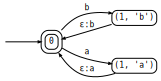

In [23]:
#m = examples.newspeak2()
#m = examples.parity({'a', 'b'})
m = examples.duplicate({'a', 'b'})
m

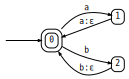

In [24]:
m.renumber.T

In [25]:
display_table([Precover(m.renumber.T, '').decomposition], headings=['quotient', 'remainder'])

In [26]:
display_table([Precover(m.renumber, '').decomposition], headings=['quotient', 'remainder'])

quotient,remainder
"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 0 <!-- start->0 --> start->0",∅


In [ ]:
for x,y in m.relation(10):
    print((''.join(x), ''.join(y)), len(x) - len(y))

In [ ]:
for x,y in m.T.relation(10):
    print((''.join(x), ''.join(y)), len(x) - len(y))

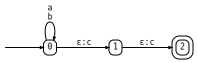

In [29]:
m = FST()
m.add_start(0)
m.add_stop(2)

# Copy everything
m.add_arc(0, 'a', 'a', 0)
m.add_arc(0, 'b', 'b', 0)

# Final extra output
m.add_arc(0, EPSILON, 'c', 1)
m.add_arc(1, EPSILON, 'c', 2)
m

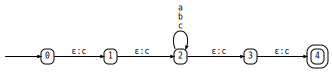

In [30]:
m = FST()
m.add_start(0)
m.add_stop(4)

m.add_arc(0, EPSILON, 'c', 1)
m.add_arc(1, EPSILON, 'c', 2)

# Copy everything
m.add_arc(2, 'a', 'a', 2)
m.add_arc(2, 'b', 'b', 2)
m.add_arc(2, 'c', 'c', 2)

# Final extra output
m.add_arc(2, EPSILON, 'c', 3)
m.add_arc(3, EPSILON, 'c', 4)
m

In [31]:
assert delay_bound(m) < np.inf

{0: 0, 1: -1, 2: -2, 3: -3, 4: -4}


In [32]:
assert not has_unbounded_output_lag(m)

In [63]:
display_table([Precover(m, 'ccabc').decomposition], headings=['quotient', 'remainder'])

In [86]:
display_table([Precover(m.renumber, 'ccabccabcc').decomposition], headings=['quotient', 'remainder'])

quotient,remainder


Note that the notion of a quotient can be brittle. For example, there might be a small (finite) set of exceptions to `xyz` being a cylinder of the precover, which we could handle by subtraction.  Rather than enumerating them in the remainder.

In other words, we could decompose the precover as

Our current decomposition method factors things like:
$$
P = Q \mathcal{X}^* \sqcup R
$$

And this extended thing could factor like

$$
P = (Q \mathcal{X}^* - E)
$$

Or maybe even
$$
P = (Q \mathcal{X}^* - E \mathcal{X}^*)
$$


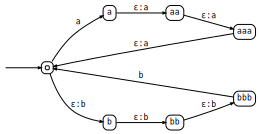

In [87]:
m = FST()
m.add_start('')
m.add_stop('')

m.add_arc('', 'a', 'a', 'a')
m.add_arc('a', '', 'a', 'aa')
m.add_arc('aa', '', 'a', 'aaa')
m.add_arc('aaa', '', 'a', '')

m.add_arc('', '', 'b', 'b')
m.add_arc('b', '', 'b', 'bb')
m.add_arc('bb', '', 'b', 'bbb')
m.add_arc('bbb', 'b', 'b', '')
m

In [88]:
assert delay_bound(m) == np.inf

In [89]:
assert not has_unbounded_output_lag(m) 

In [90]:
#list(m.relation(10))

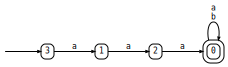

In [91]:
Precover(m, 'aaaaaaaaa')

In [92]:
from itertools import combinations

In [103]:
def _build_twin_graph(m):
    """
    Build twin graph over unordered pairs {p, q}, p != q, with edge weights
    w = |out1| - |out2|.
    """
    # Represent unordered pair {p, q} canonically as (min, max)
    def canon_pair(p, q):
        return (p, q) if p < q else (q, p)

    twin_adj = defaultdict(list)

    # For every unordered pair of distinct states
    for p, q in combinations(m.states, 2):
        pair = canon_pair(p, q)
        # Same input symbol a on both sides
        symbols = {x for x,_,_ in m.arcs(p)} & {x for x,_,_ in m.arcs(q)}
        for a in symbols:
            for out1, p_next in m.arcs(p, a):
                for out2, q_next in m.arcs(q, a):
                    # Compute weight w = |out1| - |out2|
                    w = (out1 != EPSILON) - (out2 != EPSILON)
                    if p_next == q_next:
                        # Once both runs coalesce to the same state, no need to track that pair:
                        # delay from this point is zero on future transitions it shares.
                        continue

                    twin_adj[pair].append((canon_pair(p_next, q_next), w))

    return twin_adj

In [104]:
_build_twin_graph(f)

defaultdict(list,
            {(0, 1): [((0, 3), 0)],
             (0, 2): [((1, 2), 0), ((1, 2), 0), ((0, 4), 0)],
             (0, 3): [((0, 5), 0)],
             (0, 4): [((1, 2), 0), ((1, 2), 0)],
             (1, 2): [((3, 4), 0)],
             (1, 4): [((0, 3), 0)],
             (2, 3): [((0, 5), 0)],
             (2, 4): [((1, 2), 0), ((1, 2), 0), ((0, 4), 0)],
             (5, 6): [((6, 7), 0)],
             (5, 7): [((0, 6), 0)],
             (6, 7): [((0, 7), 0)]})